In [16]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm

In [17]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]

In [18]:
raw_data = {}

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

raw_data['de_corona'] = pd.read_csv(corona, sep='\s+', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\s+', parse_dates=['date'], date_parser=dateparse)

In [19]:
raw_data['de_corona']

,date,region_code,confirmed_addition,deceased_addition
0,2020-01-02,Nordrhein-Westfalen,1,0
1,2020-01-07,Nordrhein-Westfalen,1,0
2,2020-01-09,Nordrhein-Westfalen,1,1
3,2020-01-12,Nordrhein-Westfalen,1,0
4,2020-01-14,Nordrhein-Westfalen,1,0
...,...,...,...,...
5597,2021-02-21,Rheinland-Pfalz,120,0
5598,2021-02-21,Sachsen,68,0
5599,2021-02-21,Sachsen-Anhalt,84,0
5600,2021-02-21,Schleswig-Holstein,113,0


In [20]:
raw_data['weather']

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573
...,...,...,...,...,...,...,...,...,...
14899,2020-11-14,SE-U,93.442738,4.831112e+04,2.410483e+06,279.246340,0.000360,0.000000,2.022863
14900,2020-11-14,SE-W,94.633991,1.790715e+04,2.316636e+06,277.356327,0.002467,0.000000,2.660086
14901,2020-11-14,SE-X,91.194131,3.040221e+04,2.371160e+06,278.566463,0.000939,0.000000,2.286798
14902,2020-11-14,SE-Y,89.264026,1.481068e+04,2.359827e+06,278.493415,0.001144,0.000000,3.152586


In [22]:
raw_data['de_corona'].reset_index(inplace=True)
#df.columns = ['Date','sum']
raw_data['de_corona'].head()
raw_data['de_corona']['month'] = raw_data['de_corona']['date'].dt.strftime('%b')
raw_data['de_corona']['month']

0       Jan
1       Jan
2       Jan
3       Jan
4       Jan
       ... 
5597    Feb
5598    Feb
5599    Feb
5600    Feb
5601    Feb
Name: month, Length: 5602, dtype: object

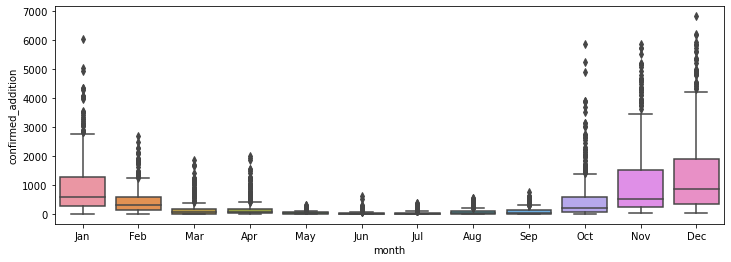

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='confirmed_addition',data=raw_data['de_corona'],ax=ax)
plt.show()